# Pyladies meetup <img src="https://raw.githubusercontent.com/pyladies/pyladies-assets/master/geek/png/pylady_geek_partial.png" style="display:inline" width="150"  align="right">
# 6. házi feladat megoldása

In [ ]:
import pandas as pd

In [ ]:
def hhead(df, n=5):
    print(df.shape)
    return df.head(n)

In [ ]:
df = pd.read_csv('bergengoc_nepszamlalas_tisztitott.csv')
hhead(df)

---

Geeky úgy döntött, hogy ugyanilyen sorrendben halad majd a feladatokkal, így először a megye szintű adatokat kérte el. Beolvasva a táblát majdnem leesett a székből, olyan érthetetlen módon tárolták ezeket az adatokat, de átgondolva a lépéseket arra juott, hogy a következő parancsok megfelelő kombinációjával normális formátumra tudja hozni az adatokat (a parancsok abc sorrendben vannak):
- dropna
- pivot
- rename
- reset_index (2x)
- unstack

A megfelelő kombinálás után Geeky egy (10, 5) alakú táblázatot kapott, ahol az oszlopok a [megye, lakosság, népsűrűség, települések_száma, terület], míg a sorokban az egyes megyékhez tartozó értékek tartoznak.

Geeky utolsó lépésként még hozzácsatolta ezt az új táblát a tegnap létrehozott, tisztított adattáblához.


In [ ]:
megye = pd.read_csv('megye_tulajdonsag.csv', sep=';', header=[0,1], index_col=0)
megye

In [ ]:
# UNSTACK - eredeti táblázatot szétbontjuk
megye = megye.unstack()

# RESET_INDEX - indexekből oszlopot csinálunk
megye = megye.reset_index()

# RENAME - oszlopok átnevezzük
megye = megye.rename(columns={'level_0': 'tulajdonsag', 'level_1': 'elhelyezkedes', 'level_2': 'megye_nev', 0: 'ertek'})

# DROPNA - NaN értékeket eltávolítjuk
megye = megye.dropna()

# PIVOT - átrendezzük a táblázatot a kívánt (10,5) formába
megye = megye.pivot(index='megye_nev', columns='tulajdonsag', values='ertek')
megye.columns.name = None  # Eltávolítjuk az oszlopok nevének címkéjét

# a 'terulet' és a 'terület' oszlop értékeit egyesítjük + a 'terület' oszlop eltávolítjuk, 
# hogy a végére majd tényleg csak 5 oszlopunk legyen - bár ehhez nem volt FILLNA parancsunk, 
# de én enélkül nem tudom összehozni a kívánt formátumot
megye['terulet'] = megye['terulet'].fillna(megye['terület'])
megye = megye.drop(columns='terület')

# RESET_INDEX - létrehozzuk a 'megye' oszlopot
megye = megye.reset_index()
megye

In [ ]:
df.head()

In [ ]:
megye.head()

In [ ]:
merged_df = pd.merge(df, megye, left_on='lakhely_megye', right_on='megye_nev', how='left')
merged_df

#### és ha rajtam múlna még egy kicsit tovább alakítanám ezt az összekapcsolt táblát a 'kor' és 'lakhely_megye' oszlopok felcserélésével és a 'megye_nev' oszlop kihagyásával

new_order = ['uj_ID', 'keresztnev', 'szuletesi_ev', 'nem', 'magassag', 
             'BMI', 'nepcsoport', 'kor', 'lakhely_megye', 'lakossag', 
             'nepsuruseg', 'telepulesek_szama', 'terulet']

merged_df = merged_df[new_order]

merged_df

---

Végignézve az adatokat Geeky elgondolkodott, hogy vajon melyik megyében található Bergenburg, majd rövid töprengés után megkérdezte a hivatalnokot, hogy a tippje jó-e.
(Írjátok le egy külön cellába, print-tel, hogy melyik megyére tippeltek, és miért!)

In [ ]:
print('Bergenburg talán BERFALU megyében található')
print("""Indoklás: a fővárosok gyakran a legnagyobb városok közé tartoznak - 
így talán itt élnek a legtöbben, szóval akkor a legnagyobb lélekszámú / legsűrűbben lakott megyében kell lennie.""")

---

Geeky nem lassított, és már kezdett is neki a következő, idősoros adatnak. Beolvasva az adatokat megértette, hogy eddig miért csak "szemmel veréssel" tudtak bármit megállapítani a hivatalban, így első lépésként itt is az átalakításokkal kezdte.

Az átalakítás itt is több lépésből áll, ahol új oszlopot is kellett csinálnia, a melt függvényt is használni, időbélyeg formátumra alakítani, indexet állítani, és eldobni a felesleges oszlopokat, hogy a végére egy olyan táblázatot kapjon, aminek az indexében az időpontok, "népesség nevű oszlopában pedig a népességi adatok találhatóak, időrendben (dátum mentén növekvő).
Geeky azt is kezelte, hogy az utolsó két hiányzó érték az azért hiányzik, hiszen az a népszámlálás időpontjában még a jövőben voltak, így azokat eldobta.

In [ ]:
df_ido = pd.read_csv('nepszamlalas_hist.csv', sep=';', dtype={0:'str',
                                                            1: 'float',
                                                            2: 'float',
                                                            3: 'float',
                                                            4: 'float'})
df_ido

In [ ]:
# MELT - eredeti táblázatot átalakítjuk 2 oszlopossá
df_ido = pd.melt(df_ido, id_vars=['év'], value_vars=['01.01', '04.01', '07.01', '10.01'],
                         var_name='honap_nap', value_name='nepesseg')

# létrehozzuk a DATUM oszlopot (időbélyeg formátumban)

# először az "év" oszlopból eltávolítjuk a tizedesjegyet, mert különben a .to_datetime() hibára fut
df_ido['év'] = df_ido['év'].str.extract('(\d+)') 
# nem az utolsó karaktert vágjuk le, hanem a számjegyet "nyerjük ki", hogy egy esetleges elgépelésnél, se legyen gond

# mostmár létrehozható a DATUM oszlop
df_ido['datum'] = pd.to_datetime(df_ido['év'] + df_ido['honap_nap'], format='%Y%m.%d')

# TOVÁBBI FORMÁZÁSOK

# felesleges oszlopokat elhagyjuk, maradékot átrendezzük; sorokat dátum szerint rendezzük
df_ido = df_ido[['datum', 'nepesseg']].sort_values(by='datum')

# 'datum' oszlopot indexé alakítjuk és az utolsó két (NaN) sort töröljük
df_ido = df_ido.set_index('datum')
df_ido = df_ido.iloc[:-2]

df_ido

---

A tábla kialakítás után Geeky ábrázolta az adatokat, és feltűnt neki, hogy vannak hiányzó értékek - feltehetőleg valamiért azokban az időpontokban nem tudták megtartani a népszámlálást - így Geeky fel szeretné tölteni ezeket.
Először kipróbálta mindhárom tanult módszert, vizuálisan ábrázolta is (a pandas beépített módszerével), majd kiválasztotta a számára legszimpatikusabbat, azt a módszert megtartotta, és úgy haladt tovább. A hivatalnoknak elmagyarázta, hogy miért azt a módszert választotta.

(a kódban maradjon benne mind a három módszer ábrázolása, és egy külön cellába, print-vel írjátok ki, hogy melyik módszer mellett döntöttetek, és miért!)

In [ ]:
df_ido.plot()

In [ ]:
df_ido.fillna(method="ffill").plot()

In [ ]:
df_ido.fillna(method="bfill").plot()

In [ ]:
df_ido.interpolate().plot()

In [ ]:
print("""Szerintem Geeky az interpolációs módszer választotta.
Mivel népesség számról van szó, így nehezen elképzelhető, hogy volt olyan időszak, ahol \
konstans ugyanannyi volt a lélekszám 3 - 6 - 9 hónap elteltével. Sokkal valószínűbb, \
hogy fokozatosan változott a népesség, nem pedig hirtelen egyik mérésről a másikra zuhant meg \
vagy nőtt meg a létszám. Ezt viszont az interpolációs módszer adja vissza legjobban.""")
print("""BTW amúgy is az interpoláció a 'legkockább' megoldás, így szerintem biztosan \
az a legszimpatikusabb Geekynek :)""")

---

A hiányzó értékek feltöltése után Geeky mozgóátlagokat számolt, és ábrázolta azokat (a pandas beépített módszerével). 3 féle mozgó ablakkal dolgozott:
- fél éves
- 1 éves
- 2 éves

In [ ]:
df_ido = df_ido.interpolate()
df_ido

In [ ]:
df_ido['mozgo_atlag_6m'] = df_ido['nepesseg'].rolling(3).mean()
df_ido['mozgo_atlag_12m'] = df_ido['nepesseg'].rolling(5).mean()
df_ido['mozgo_atlag_24m'] = df_ido['nepesseg'].rolling(9).mean()

df_ido

In [ ]:
df_ido.plot()

Végezetül pedig Geeky kiszámolta egy új oszlopba, hogy mennyi volt a népesség változás egyik időpontról a másikra, majd pedig megintcsak egy új változóban megnézte, hogy az első időponthoz képest mennyi volt a teljes változás - minden időponton (cumsum), és a végén megmondta a hivatalnoknak, hogy az első népszámláláshoz képest hány fővel változott Bergengócia lakossága az aktuális felméréssel összevetve.
- (Írjuk ki egy külön cellába, print segítségével, hogy mennyit változott a népesség az első és az utolsó mérés között)

In [ ]:
df_ido['nepesseg_diff'] = df_ido['nepesseg'].diff()
df_ido

In [ ]:
df_ido[['nepesseg_diff']].cumsum()

In [ ]:
nepesseg_valtozas = df_ido['nepesseg'][-1] - df_ido['nepesseg'][0]

if nepesseg_valtozas < 0:
    print('A népesség ' + str(int(abs(nepesseg_valtozas))) + ' fővel csökkent az első és az utolsó mérés között')
elif nepesseg_valtozas > 0:
    print('A népesség ' + str(int(nepesseg_valtozas)) + ' fővel növekedett az első és az utolsó mérés között')
else:
    print('A népesség nem változott az első és az utolsó mérés között')

---

Utolsó feladatként az előző elemzés alapján az ábrák létrehozása maradt. Geeky érezte, hogy ehhez a pandas vizualizációs képességei már nem elegendőek, ezért egyik szeretett csomagjához, a plotnine-hoz fordult.

* _Megjegyzés - az adat generált adat, így nem érdemes benne összefüggéseket keresni, mert sajnos nem lesznek_

In [ ]:
from plotnine import *

In [ ]:
df.head(1)

Geeky először egy hisztogramot készített, amelyen a "kor" változó eloszlását ábrázolta, 30 csoportra bontva. Az oszlopok körvonalát pirosra, a színét pedig sötétkékre állította.

In [ ]:
ggplot(df) + aes(x="kor") + geom_histogram(bins=30, color='red', fill='darkblue') \
        + ggtitle("ÉLETKOR ELOSZLÁS HISZTOGRAM")

---

A második ábrához kapott egy mintát, amit reprodukálnia kell a jelenlegi adatok alapján _(ha nem jelenne meg a fénykép: hf_viz_2.feladat.png)_:
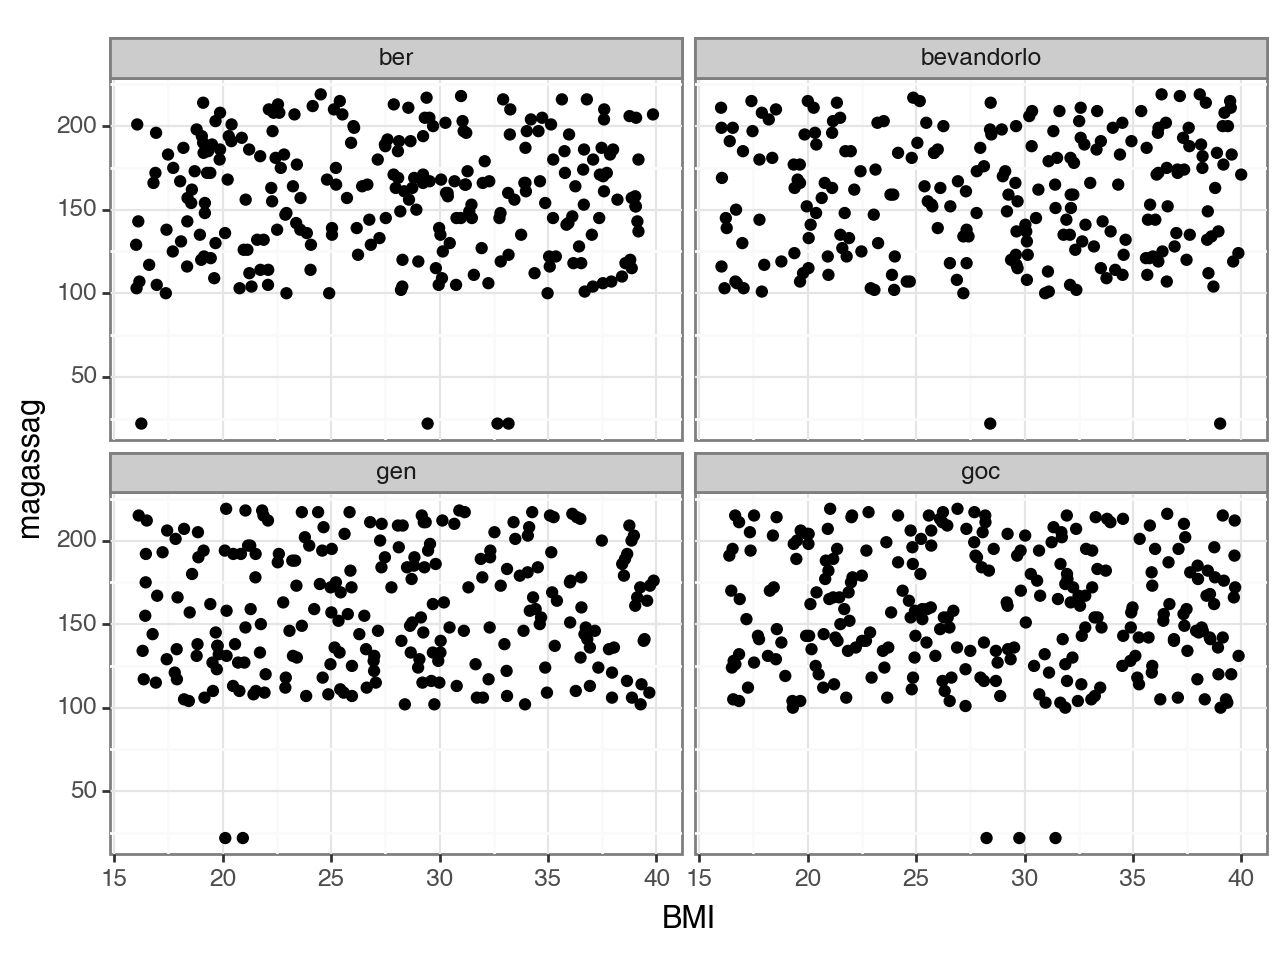

In [ ]:
ggplot(df) + aes(x="BMI", y="magassag") + geom_point(alpha=0.5) \
        + facet_wrap("nepcsoport", nrow=2) \
        + scale_y_continuous(breaks=[50, 100, 150, 200], limits=(12.5, 225)) \
        + theme(figure_size=(10, 6)) # ábra méretének növelése, hogy kicsit jobban láthatóak legyenek a diagramok

---

Harmadik ábránál egy oszlopdiagramot szeretne a hivatalnok, ami népcsoportonként mutatja meg, hogy mekkora a lakosság, méghozzá a nemek szerint színezve az egyes oszlopokat.

In [ ]:
# későbbi ellenőrzés céljából lekérem, az egyes kategóriák elemszámát
tmp = df.groupby(['nepcsoport', 'nem']).count().uj_ID
tmp

In [ ]:
ggplot(df) + aes(x="nepcsoport", fill='nem') + geom_bar(position="dodge", color='green') \
        + ggtitle("LAKOSSÁG LÉTSZÁMA NÉPCSOPORTONKÉNT ÉS NEMENKÉNT") \
        + theme(figure_size=(8, 4))

---

Végül pedig egy elég összetett ábrára kíváncsi a hivatalnok, ahol:
- csak a férfi és női lakosság érdekli
- a kor és a magasság viszonyára vagyunk kíváncsiak, a pontokat a nem szerint színezve
- a lakhely és a népcsoport szerint külön kis ábrákra bontva (facet_grid)
- világos (light) téma szerint
- ügyelve arra, hogy minden megye neve olvasható legyen

In [ ]:
# először leszűrjük a táblát, hogy csak a férfi/nő lakosokkal dolgozzunk tovább
df = df[(df['nem'] == 'no') | (df['nem'] == 'ferfi')]
df.shape

In [ ]:
ggplot(df) + aes(x ='kor' , y = 'magassag', color='nem') + geom_point(alpha=0.5) \
        + facet_grid('lakhely_megye ~ nepcsoport') \
        + theme_light() \
        + theme(figure_size=(8, 12))

---

Geeky úgy döntött, hogy még van ideje arra, hogy meglepje a hivatalnokot egy extra diagrammal, mielőtt megérkezik az étel, így gyorsan elkészítette egyet saját gondolatai alapján.
Pont befejezte, mikor megérkezett a pincér az előétellel, így elégedetten csukta le szeretett Python-i-Max III. laptopját, hogy figyelmét a finom ételek és a hivatalnok "faggatására" fordítsa.

In [ ]:
import numpy as np

x = np.linspace(-1, 1, 100)
y = 0.85*x**2 - 0.2

eye_y = 1
eye_x_left = -0.4
eye_x_right = 0.4
eye_size = 3

ggplot() \
    + geom_point(aes(x=eye_x_left, y=eye_y), size=eye_size, color="blue") \
    + geom_segment(aes(x=eye_x_right, xend=eye_x_right + 0.2, y=eye_y, yend=eye_y), size=1.5, color="blue") \
    + geom_path(aes(x=x, y=y), color="blue", size=2) \
    + coord_fixed(ratio=1) \
    + theme_void() \
    + theme(figure_size=(4, 4))

